## BoilerPlate command

It’s standard practice to start the notebook with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.



In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Importing Fast AI library

Let’s import fastai library and define our batch_size parameter to 64. Usually, image databases are enormous, so we need to feed these images into a GPU using batches, batch size 64 means that we will feed 64 images at once to update parameters of our deep learning model. If you are running out of memory because of smaller GPU RAM, you can reduce batch size to 32 or 16.

In [2]:
from minivggnet import *
from fastai.vision.all import *
from sklearn.metrics import classification_report
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context='notebook', ticks=True, grid=False)
bs=256

## Downloading Dataset

In [3]:
path = untar_data(URLs.CIFAR, dest="../data/");
path

Path('../data/cifar10')

In [4]:
path.ls()

(#4) [Path('../data/cifar10/labels.txt'),Path('../data/cifar10/models'),Path('../data/cifar10/test'),Path('../data/cifar10/train')]

In [5]:
(path/'train').ls()

(#10) [Path('../data/cifar10/train/airplane'),Path('../data/cifar10/train/automobile'),Path('../data/cifar10/train/bird'),Path('../data/cifar10/train/cat'),Path('../data/cifar10/train/deer'),Path('../data/cifar10/train/dog'),Path('../data/cifar10/train/frog'),Path('../data/cifar10/train/horse'),Path('../data/cifar10/train/ship'),Path('../data/cifar10/train/truck')]

In [6]:
(path/'train/airplane').ls()[1:5]

(#4) [Path('../data/cifar10/train/airplane/10010_airplane.png'),Path('../data/cifar10/train/airplane/10020_airplane.png'),Path('../data/cifar10/train/airplane/10024_airplane.png'),Path('../data/cifar10/train/airplane/10031_airplane.png')]

## Importing Data

In [7]:
cifar = DataBlock(blocks=(ImageBlock(), CategoryBlock), 
                  get_items=get_image_files, 
                  #splitter=RandomSplitter(0.2),
                  splitter=GrandparentSplitter(train_name='train', valid_name='test'),
                  get_y=parent_label,
                  item_tfms=Resize(32),
                  batch_tfms=None)
dls = cifar.dataloaders(path, bs=bs)

In [8]:
dls.train_ds

(#50000) [(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0))...]

In [9]:
dls.valid_ds

(#10000) [(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0))...]

(#10) ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
10


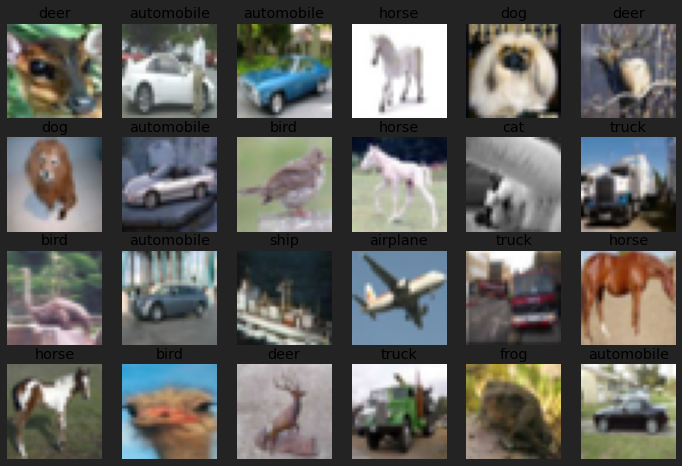

In [10]:
print(dls.vocab) ## Prints class labels
print(dls.c) ## Prints number of classes
dls.show_batch(max_n=24, figsize=(12,8)) ## Show sample data

## About the model

Minivggnet is just a smaller version of VGG family of model which contains all the key elements to build an actual VGG model. It's just miniature version which can do reasonably well without requiring a lot of compute time. The model is having following architecture -

((CONV=>ACT=>BN)x2 =>POOL=>DO)x2=>FC=>ACT=>DO=>FC=>SOFTMAX

Glossary-
- CONV -> Convolution with kernel size 3x3 with same padding
- ACT -> ReLU Activation
- BN -> Batch Normalization
- DO -> Dropout
- Pool -> Max pooling with size 2x2
- FC -> Fully connected layer

## Training the model

We have defined our shallownet model in shallownet.py file, now we need to train it. We can use FastAI's *Learner* function which makes it easier to leverage modern enhancement in optimization methods and many other neat tricks like  1-Cycle style training as highlighted in [Leslie Smith's paper](https://arxiv.org/pdf/1803.09820.pdf) for faster convergence. Let's define our Learner class -

In [12]:
## Defining the learner
minivgg_learner = Learner(
    dls=dls, 
    model=MiniVGGNet(batch_norm=True, size=32, n_class=dls.c), 
    pretrained=False,
    loss_func=nn.CrossEntropyLoss(),
    model_dir=path/"models",
    metrics=accuracy
)

In [13]:
minivgg_learner.summary()

VGG (Input shape: ['256 x 3 x 32 x 32'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               256 x 32 x 32 x 32   896        True      
________________________________________________________________
ReLU                 256 x 32 x 32 x 32   0          False     
________________________________________________________________
BatchNorm2d          256 x 32 x 32 x 32   64         True      
________________________________________________________________
Conv2d               256 x 32 x 32 x 32   9,248      True      
________________________________________________________________
ReLU                 256 x 32 x 32 x 32   0          False     
________________________________________________________________
BatchNorm2d          256 x 32 x 32 x 32   64         True      
________________________________________________________________
MaxPool2d            256 x 32 x 16 x 16   0          False     
_________________________________________________________

SuggestedLRs(lr_min=0.002290867641568184, lr_steep=0.0005754399462603033)

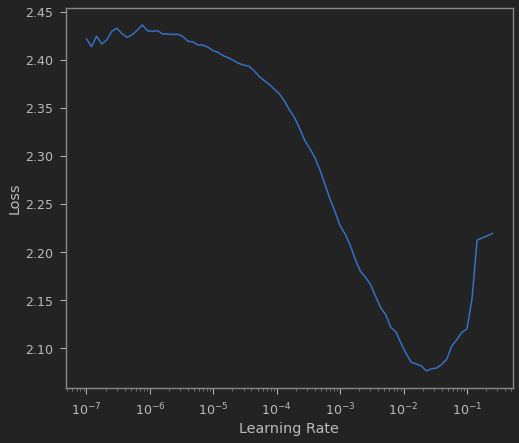

In [14]:
## Finidng Ideal learning late
minivgg_learner.lr_find()

In [15]:
minivgg_learner.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.264416,1.282443,0.546900,01:10
1,1.230391,1.152376,0.607600,01:06
2,0.962623,0.862644,0.702400,01:03
3,0.862761,0.748894,0.743900,01:08
4,0.778118,0.733371,0.743600,01:05
5,0.672497,0.640347,0.782100,01:02
6,0.561119,0.609556,0.793900,01:05
7,0.459156,0.565482,0.811100,01:03
8,0.372575,0.535806,0.825900,01:05
9,0.337832,0.539671,0.828100,01:03


In [16]:
interp = ClassificationInterpretation.from_learner(minivgg_learner)
print(classification_report(np.array(interp.preds).argmax(axis=1), interp.targs))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1002
           1       0.90      0.93      0.92       975
           2       0.72      0.77      0.75       941
           3       0.65      0.66      0.65       975
           4       0.81      0.80      0.81      1019
           5       0.74      0.76      0.75       971
           6       0.90      0.84      0.87      1075
           7       0.86      0.88      0.87       987
           8       0.92      0.90      0.91      1016
           9       0.91      0.88      0.90      1039

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

